In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from exp.nb_10 import *

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [5]:
# does not use ANY of previous lesson cool data aug. For testing new data aug purposes
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor] 
bs = 64

In [6]:
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

# Mix up

https://arxiv.org/abs/1710.09412

Train the model on a mix of the pictures of the training set. 

Instead of feeding the model the raw images, we take two (which could be in the same class or not) and do a linear combination of them: in terms of tensor it's

```new_image = t * image1 + (1-t) * image2```

t is a float between 0 and 1

Then the target we assign to that image is the same combination of the original targets:

```new_target = t * target1 + (1-t) * target2```

assuming your targets are one-hot encoded (which isn't the case in pytorch usually).

E.g. if you have 10 classes and you mixup 2 image of class 0 and class 3 with ratio 70:30, this will be your 'one hot' label:

new_mixup_img = [0.7 0 0 0.3 0 0 0 ...]


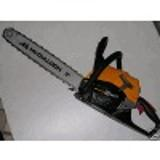

In [7]:
img1 = PIL.Image.open(ll.train.x.items[0])
img1

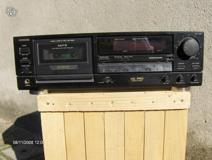

In [10]:
img2 = PIL.Image.open(ll.train.x.items[5000])
img2

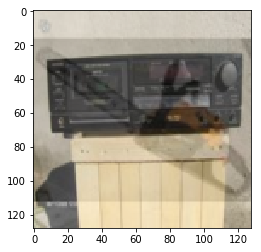

In [11]:
mixed_up = ll.train.x[0] * 0.3 + ll.train.x[5000] * 0.7
plt.imshow(mixed_up.permute(1,2,0));

# Randomized t (lamda) using gamma function (beta distribution)

Gamma function: factorial function that (kinda) interpolates nice and smoothly to non-integers ???

In [12]:
Γ = lambda x: x.lgamma().exp()

In [13]:
facts = [math.factorial(i) for i in range(7)]

In [18]:
torch.linspace(0,6) # 100 numbers by default

tensor([0.0000, 0.0606, 0.1212, 0.1818, 0.2424, 0.3030, 0.3636, 0.4242, 0.4848,
        0.5455, 0.6061, 0.6667, 0.7273, 0.7879, 0.8485, 0.9091, 0.9697, 1.0303,
        1.0909, 1.1515, 1.2121, 1.2727, 1.3333, 1.3939, 1.4545, 1.5152, 1.5758,
        1.6364, 1.6970, 1.7576, 1.8182, 1.8788, 1.9394, 2.0000, 2.0606, 2.1212,
        2.1818, 2.2424, 2.3030, 2.3636, 2.4242, 2.4848, 2.5455, 2.6061, 2.6667,
        2.7273, 2.7879, 2.8485, 2.9091, 2.9697, 3.0303, 3.0909, 3.1515, 3.2121,
        3.2727, 3.3333, 3.3939, 3.4545, 3.5152, 3.5758, 3.6364, 3.6970, 3.7576,
        3.8182, 3.8788, 3.9394, 4.0000, 4.0606, 4.1212, 4.1818, 4.2424, 4.3030,
        4.3636, 4.4242, 4.4848, 4.5455, 4.6061, 4.6667, 4.7273, 4.7879, 4.8485,
        4.9091, 4.9697, 5.0303, 5.0909, 5.1515, 5.2121, 5.2727, 5.3333, 5.3939,
        5.4545, 5.5152, 5.5758, 5.6364, 5.6970, 5.7576, 5.8182, 5.8788, 5.9394,
        6.0000])

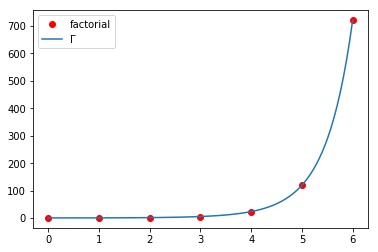

In [14]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6)+1))
plt.legend(['factorial','Γ']);

We will
- Create 2 dataloaders, and draw a batch from each at every iteration -> 2 batches from 2 dataloaders
    - Alternative: only 1 dataloaders, for a batch, we create a shuffle version of that batch and mix these 2
- Draw a t value, following a beta distribution, with parameter α (α = 0.4 suggested from article)
- Mix up 2 batches with value t
- One-hot encoded targets

tensor(inf) tensor(0.1766)
tensor(inf) tensor(0.9938)


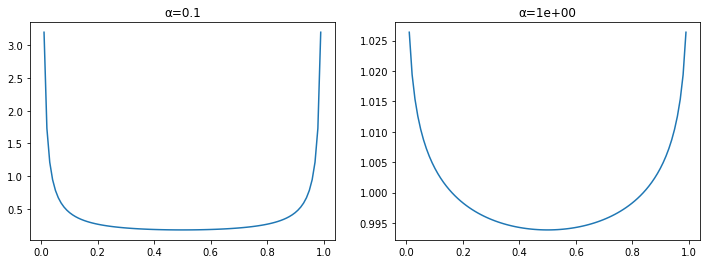

In [24]:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.1,0.99], axs):
    α = tensor(α)
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    print(y.max(),y.min())
    ax.plot(x,y)
    ax.set_title(f"α={α:.1}")

This plot is essentially the histogram of value between 0 and 1 (**sampling from this probability distribution**)

With low value of α, we have a high chance to pick something close to 0 and 1, to signify that we want it to be either this or that. 

Only occasionally we pick a value ~0.5 so that we can have something evenly mixed once in a while

Example from this distribution from pytorch

In [38]:
from torch.distributions.beta import Beta

(array([403.,  45.,  30.,  17.,  19.,  22.,  16.,  28.,  38., 382.]),
 array([1.175494e-38, 9.999999e-02, 2.000000e-01, 3.000000e-01, 4.000000e-01, 5.000000e-01, 6.000000e-01, 6.999999e-01,
        8.000000e-01, 9.000000e-01, 9.999999e-01], dtype=float32),
 <a list of 10 Patch objects>)

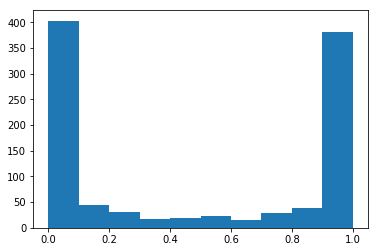

In [41]:
temp_beta =.1
temp = Beta(tensor([temp_beta]),tensor([temp_beta]))
plt.hist(temp.sample((1000,)).squeeze())

(array([139.,  81., 100.,  83.,  90.,  95.,  78.,  83., 115., 136.]),
 array([2.316558e-05, 1.000117e-01, 2.000003e-01, 2.999889e-01, 3.999774e-01, 4.999660e-01, 5.999545e-01, 6.999431e-01,
        7.999317e-01, 8.999202e-01, 9.999088e-01], dtype=float32),
 <a list of 10 Patch objects>)

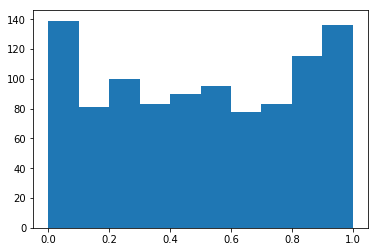

In [42]:
temp_beta =.8
temp = Beta(tensor([temp_beta]),tensor([temp_beta]))
plt.hist(temp.sample((1000,)).squeeze())

# Calculate loss

We don't actually convert our label to one=hot. as we will compute 2 losses and then do linear combination

E.g.: for 4-class proble: 
- img with class 1: [1 0 0 0] and softmax output [.7 .1 .1 .1] will have logloss: 1 * log(.7) = log(.7)
- img with class 3: [0 0 1 0] and softmax output [.7 .1 .1 .1] will have logloss: 1 * log(.1) = log(.1)

=>  mixup img with t=.7: [.7 0 .3 0] and nn output [.7 .1 .1 .1] will have logloss: .7 * log(.7) + .3 * log(.1)

Or ```loss(output, new_target) = t * loss(output, target1) + (1-t) * loss(output, target2)```

Using the same parameter t for the whole batch also seemed a bit inefficient. In our experiments, we noticed that **the model can train faster if we draw a different t for every image in the batch** (both options get to the same result in terms of accuracy, it's just that one arrives there more slowly).

If we use different t for each image, there might be duplicate (t1=0.1 for img0 mixed with img1 == t2=0.9 for img1 mixed with img0)

This is rare, but can result in worse accuracy. To avoid this, we have to make sure t2 (of next img) != 1-t1 (of current img), or t always >=0.5. We insure that the biggest coefficient is always near the first image (the non-shuffled batch).

```t = max(t, 1-t)```

In [30]:
from torch.distributions.beta import Beta # for Pytorch's Beta distribution mentioned above

def unsqueeze(input, dims):
    # add dimension size 1 in dims positions
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [29]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x7fd1985c3320>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

In [43]:
temp_beta =.1
temp_t = Beta(tensor([temp_beta]),tensor([temp_beta]))
temp_t = temp.sample((1000,)).squeeze()

In [45]:
temp_t[:5]

tensor([0.3896, 0.6512, 0.6296, 0.9301, 0.5728])

In [46]:
temp_t = torch.stack([temp_t,1-temp_t],1)

In [53]:
temp_t[:10,:]

tensor([[0.3896, 0.6104],
        [0.6512, 0.3488],
        [0.6296, 0.3704],
        [0.9301, 0.0699],
        [0.5728, 0.4272],
        [0.1101, 0.8899],
        [0.4190, 0.5810],
        [0.1290, 0.8710],
        [0.0642, 0.9358],
        [0.5704, 0.4296]])

In [61]:
class NoneReduce():
    def __init__(self, loss_func): 
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)

In [60]:
# main class for mixup

class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda. This is done on GPU!
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device) # this is our 't's for a batch
        λ = torch.stack([λ, 1-λ], 1)  # stack t and (1-t) horizontally
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3)) # apply max t and expand to (bs,1,1,1)
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle] # new shuffle batch
        self.run.xb = lin_comb(self.xb, xb1, self.λ) # linear combination of 2 batches
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb) # use original loss func for validation
        with NoneReduce(self.old_loss_func) as loss_func: # make sure loss_func does not have any reduction at this point
            loss1 = loss_func(pred, yb) # loss(output, target1)
            loss2 = loss_func(pred, self.yb1) # loss(output, target2)
        loss = lin_comb(loss1, loss2, self.λ) #linear comb
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean')) # change loss reduction back to mean

In [62]:
nfs = [32,64,128,256,512]

In [63]:

def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [64]:

cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, 
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixUp]

In [65]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [67]:
learn.loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

In [69]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.058745,0.338685,1.531748,0.468000,00:06


# Problem with softmax in Mixup

As you can see, we are using cross_entropy which involves using Softmax at the final output of the model, and softmax does not like mixed output

## Label smoothing

instead of wanting to predict 1 for the correct class and 0 for all the others (the case of softmax), we ask it to 
- **predict 1-ε for the correct class** (by multiply 1-ε to the log softmax, though only the high log softmax is picked out due to nll) 
- and **ε for all the others (also including the correct class)** (by multiply ε to the the log softmax, aka ```mean(mean(ε * log_softmax),axis=-1)```)

With ε a (small) positive number and N the number of classes

Loss function: ```(1-ε) * nlogloss + ε * mean(mean(-log_softmax, axis=-1))```

In [114]:
temp = tensor([[-2.,-1.,5.,1.],[1.,0.1,-1.,0.1]])
temp_target = tensor([2,1])

In [115]:
print(F.softmax(temp,dim=-1)) # softmax with no log
temp_log_preds = F.log_softmax(temp,dim=-1)
print(temp_log_preds) # softmax with log. TODO: should this be divided by c ?

tensor([[8.9251e-04, 2.4261e-03, 9.7875e-01, 1.7927e-02],
        [5.1322e-01, 2.0866e-01, 6.9457e-02, 2.0866e-01]])
tensor([[-7.0215, -6.0215, -0.0215, -4.0215],
        [-0.6670, -1.5670, -2.6670, -1.5670]])


In [116]:
temp_nll = -(temp_log_preds[0,temp_target[0]] + temp_log_preds[1,temp_target[1]])/2 # nll
temp_nll

tensor(0.7943)

In [86]:
temp_log_preds.sum(dim=-1)

tensor([-17.0859,  -6.4682])

In [117]:
# same as reduce_loss(-temp_log_preds.sum(dim=-1), 'mean')/4
temp_other_loss = -temp_log_preds.mean(dim=-1).mean()
temp_other_loss

tensor(2.9443)

In [120]:
# final loss:
lin_comb(temp_other_loss,temp_nll,0.1)

tensor(1.0093)

In [121]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    # note that this calculation will count toward gradient
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1) # (bs,# classes)
        other_loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction) # mean(sum(<log_softmax>,axis=-1))
        nll = F.nll_loss(log_preds, target, reduction=self.reduction) # normal negative log loss
        return lin_comb(other_loss/c, nll, self.ε)

In [122]:

cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [123]:

learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs, loss_func=LabelSmoothingCrossEntropy())

In [124]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.975467,0.373352,1.940046,0.414000,00:05
1,1.564959,0.551885,1.495494,0.578000,00:05
